In [1]:
# Fist install the library

#%pip install rapidae

In [2]:
import os

os.environ["KERAS_BACKEND"] = "torch"

In [3]:
import sys
import copy

notebook_dir = os.path.abspath('')
sys.path.append(os.path.join(notebook_dir, '..'))

from keras import utils
from rapidae.data.datasets import load_MNIST
from rapidae.data.utils import display_diff
from rapidae.models.base.default_architectures import Encoder_Conv_MNIST, Decoder_Conv_MNIST
from rapidae.models.vae.vae_model import VAE
from rapidae.pipelines.training import TrainingPipeline

In [4]:
# Load MNIST dataset
x_train, y_train, x_test, y_test = load_MNIST(persistant=True)

y_train_orig = copy.copy(y_train)
y_test_orig = copy.copy(y_test)

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
print(x_train.shape)
# Obtaint number of clasess
n_classes = len(set(y_train))

2023-12-27 14:27:41 [INFO]: train-images-idx3-ubyte.gz already exists.
2023-12-27 14:27:41 [INFO]: train-labels-idx1-ubyte.gz already exists.
2023-12-27 14:27:41 [INFO]: t10k-images-idx3-ubyte.gz already exists.
2023-12-27 14:27:41 [INFO]: t10k-labels-idx1-ubyte.gz already exists.


(60000, 28, 28, 1)


In [5]:
# Convert labels to categorical
y_train = utils.to_categorical(y_train, n_classes)
y_test = utils.to_categorical(y_test, n_classes)

In [6]:
# Model creation
model = VAE(input_dim=(x_train.shape[1], x_train.shape[2]), latent_dim=2,
            encoder=Encoder_Conv_MNIST, decoder=Decoder_Conv_MNIST, layers_conf=[32, 64])

2023-12-27 14:27:41 [INFO]: No specific dowstream task has been selected


In [7]:
pipe = TrainingPipeline(name='training_pipeline', learning_rate=0.01,
                        model=model, num_epochs=40, batch_size=128)

trained_model = pipe(x=x_train, y=y_train)

2023-12-27 14:27:41 [INFO]: +++ training_pipeline +++
2023-12-27 14:27:41 [INFO]: Creating folder in ../output_dir/training_pipeline_2023-12-27_14-27-41


Epoch 1/40


/home/lucaspc/venvs/keras_core/lib/python3.11/site-packages/keras/src/backend/common/backend_utils.py:88: UserWarning: You might experience inconsistencies accross backends when calling conv transpose with kernel_size=3, stride=2, dilation_rate=1, padding=same, output_padding=1.
  warnings.warn(



Epoch 1: loss improved from inf to 0.07030, saving model to ../output_dir/training_pipeline_2023-12-27_14-27-41/model.weights.h5
469/469 - 4s - 9ms/step - kl_loss: 1.6838e-04 - loss: 0.0703 - reconstruction_loss: 0.0701
Epoch 2/40

Epoch 2: loss improved from 0.07030 to 0.06739, saving model to ../output_dir/training_pipeline_2023-12-27_14-27-41/model.weights.h5
469/469 - 3s - 7ms/step - kl_loss: 2.6168e-07 - loss: 0.0674 - reconstruction_loss: 0.0674
Epoch 3/40

Epoch 3: loss improved from 0.06739 to 0.06737, saving model to ../output_dir/training_pipeline_2023-12-27_14-27-41/model.weights.h5
469/469 - 4s - 8ms/step - kl_loss: 1.6613e-07 - loss: 0.0674 - reconstruction_loss: 0.0674
Epoch 4/40

Epoch 4: loss improved from 0.06737 to 0.06736, saving model to ../output_dir/training_pipeline_2023-12-27_14-27-41/model.weights.h5
469/469 - 4s - 9ms/step - kl_loss: 1.7268e-07 - loss: 0.0674 - reconstruction_loss: 0.0674
Epoch 5/40

Epoch 5: loss did not improve from 0.06736
469/469 - 4s - 8

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


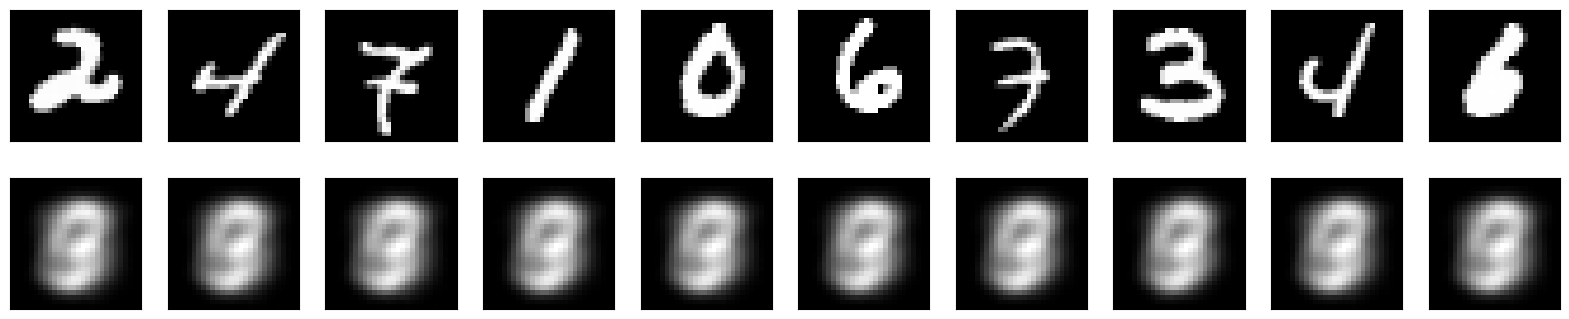

In [8]:
y_hat = trained_model.predict(x_test)

display_diff(x_test, y_hat['recon'])